# The Schwarz Criterion

The Schwarz information criterion (SIC) or the Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models; the model with the lowest BIC is preferred.

In [220]:
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt

## 1. Define models

Suppose we have two independent complex Gaussian distributions $Z_i$ and $Z_j$. We define two models:
- real_pdf is the PDF of the real part of the product of $Z_i$ and $Z_j$ (**Re**{$Z_iZ_j^*$}).
- null_pdf is the PDF of the difference between **Re**{$Z_iZ_j^*$} and **Re**{$Z_i'Z_j'^*$}.

In [171]:
def real_pdf(x, sig):
    a = 1/(sig)
    b = (-np.abs(2*x))/(sig)
    return a*np.exp(b)

def null_pdf(x, s):
    return (1/(2*s**2))*np.exp(-2*np.abs(x)/(s))*(s+2*np.abs(x))

## 2. Compute the SIC

The Schwarz criterion is defined as $\mathrm{S}=\ln(\hat{L_1})-\ln(\hat{L_2})-\frac{1}{2}(d_1-d_2)\ln(n)$ where

- $\hat L_i$ = the maximized value of the likelihood function of the model $M_i$, i.e. $\hat L=p(x\mid\widehat\theta_i,M_i)$, where $\widehat\theta_i$ are the parameter values that maximize the likelihood function
- $x$ = the observed data
- $n$ = the number of data points in $x$, the number of observations, or equivalently, the sample size
- $d_i$ = the number of parameters estimated by the model.

In [371]:
def bayes_factor_approx(data, m1, m2):
    """
    Compute the approximation value of bayes factor of a set of data fitted to two PDF models.
    
    Parameters
    ----------
    data : array_like
           Input data. The BIC is computed over the flattened array.
    m1, m2 : callable
           Models. Normal distribution is 'norm'.
    
    Returns
    -------
    s : float
           Return the Schwarz criterion.
    """

    # get histogram data
    y, x = np.histogram(data, bins='auto', density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # fit the models
    popt1 = curve_fit(m1, x, y, p0=np.std(data))[0]
#     popt1 = curve_fit(m1, x, y)[0]
    if m2 == 'norm':
        popt2 = norm.fit(data)
    else:
        popt2 = curve_fit(m2, x, y, p0=np.std(data))[0]
#         popt2 = curve_fit(m2, x, y)[0]
    
    n = len(data)
        
    # compute S
    bic1 = sum(np.log(m1(data, *popt1)))
    if m2 == 'norm':
        bic2 = sum(np.log(norm.pdf(data, *popt2)))
    else:
        bic2 = sum(np.log(m2(data, *popt2)))
    p = (len(popt1)-len(popt2))/np.log(n)
    s = 2*(bic1-bic2-0.5*p)

    return s

## Example 1

We generate an array of the product of two complex random variables. We then calculate the **average** SIC values of the array with different lengths, i.e. different numbers of data points. The plot below shows that model 1 (real_pdf) is strongly preferred than the Gaussian model when the number of data points is greater than ~100.

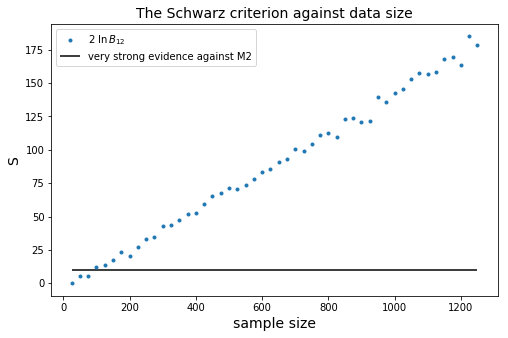

In [387]:
# compute BICs
bics = []
size = []
for i in range(50):
    b = []
    for j in range(50):
        if i == 0:
            size.append(50+50*j)
        x = np.random.normal(size=(2, size[j])).view(np.complex128)
        z = x[0, :] * x[1, :]
        z = z.real
        b.append(bayes_factor_approx(z, real_pdf, 'norm'))
    bics.append(b)
size = np.asarray(size)/2
# average BIC value for each number of data points
bics = np.mean(bics, axis=0)

# plot data points over BIC values
plt.figure(figsize=(8, 5))
plt.plot(size, bics, '.', label="2 $\ln\,{B_{12}}$")
plt.hlines(10, size[0], size[-1], label="very strong evidence against M2")
plt.xlabel("sample size", fontsize=14)
plt.ylabel("S", fontsize=14)
plt.title("The Schwarz criterion against data size", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.show()

We can also plot a histogram of the data with probability density functions predicted by two models. When the number of data points is only 50, it is hard to see which model fits better (or neither fits well).

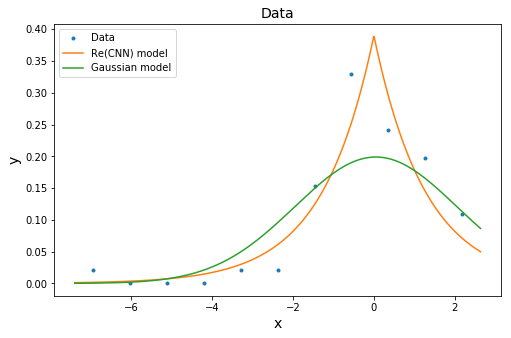

In [366]:
# generate dataset with 50 numbers of data points
x = np.random.normal(size=(2, 100)).view(np.complex128)
z = x[0, :] * x[1, :]
z = z.real

# fit the data to each model
y, x = np.histogram(z, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
sig1 = curve_fit(real_pdf, x, y, p0=np.std(z))[0]
mu = norm.fit(n)[0]
std = norm.fit(n)[1]

# plot the histogram and PDFs
xfit = np.linspace(min(z), max(z), 1000)
plt.figure(figsize=(8, 5))
y, x = np.histogram(z.real, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
plt.plot(x, y, '.', label='Data')
plt.plot(xfit, real_pdf(xfit, sig1), label='Re(CNN) model')
plt.plot(xfit, norm.pdf(xfit, mu, std), label='Gaussian model')
plt.legend(loc='best', fontsize=10)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title("Data", fontsize=14)
plt.show()

However, when we increase the number of data points to 500, the real_pdf model fits the data better.

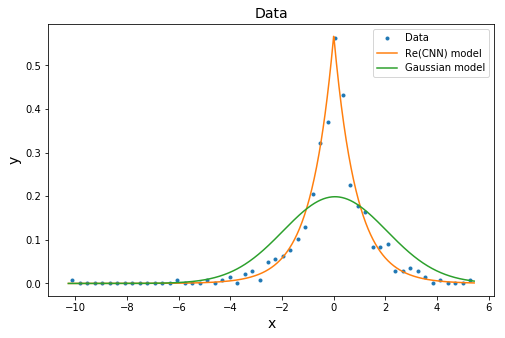

In [369]:
x = np.random.normal(size=(2, 1000)).view(np.complex128)
z = x[0, :] * x[1, :]
z = z.real

y, x = np.histogram(z, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

sig1 = curve_fit(real_pdf, x, y, p0=np.std(z))[0]
mu = norm.fit(n)[0]
std = norm.fit(n)[1]

xfit = np.linspace(min(z), max(z), 1000)
plt.figure(figsize=(8, 5))
y, x = np.histogram(z.real, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
plt.plot(x, y, '.', label='Data')
plt.plot(xfit, real_pdf(xfit, sig1), label='Re(CNN) model')
plt.plot(xfit, norm.pdf(xfit, mu, std), label='Gaussian model')
plt.legend(loc='best', fontsize=10)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title("Data", fontsize=14)
plt.show()

## Example 2

We generate an array of the difference of the product of two complex random variables. We then calculate the **average** SIC values of the array with different lengths. The plot below shows that model 2 (null_pdf) is strongly preferred than the Gaussian model when the number of data points is greater than ~500.

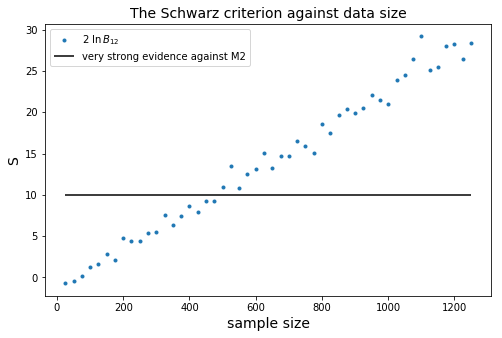

In [386]:
bics = []
size = []
for i in range(50):
    b = []
    for j in range(50):
        if i == 0:
            size.append(50+50*j)
        x1 = np.random.normal(size=(2, size[j])).view(np.complex128)
        z1 = x1[0, :] * x1[1, :]

        x2 = np.random.normal(size=(2, size[j])).view(np.complex128)
        z2 = x2[0, :] * x2[1, :]

        n = z1.real-z2.real

        b.append(bic(n, null_pdf, 'norm'))
    bics.append(b)
size = np.asarray(size)/2
bics = np.mean(bics, axis=0)

plt.figure(figsize=(8, 5))
plt.plot(size, bics, '.', label="2 $\ln\,{B_{12}}$")
plt.hlines(10, size[0], size[-1], label="very strong evidence against M2")
plt.xlabel("sample size", fontsize=14)
plt.ylabel("S", fontsize=14)
plt.title("The Schwarz criterion against data size", fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.show()

When we have only 200 data points, it is hard to tell which model is preferred by observing the PDF plots.

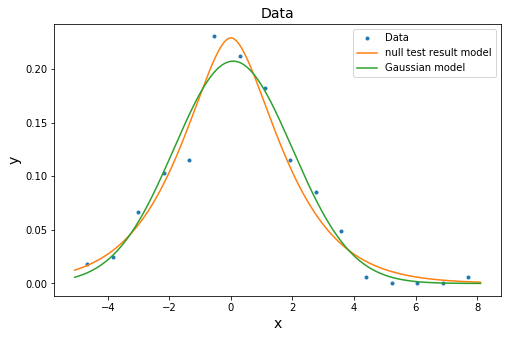

In [278]:
x1 = np.random.normal(size=(2, 400)).view(np.complex128)
z1 = x1[0, :] * x1[1, :]
x2 = np.random.normal(size=(2, 400)).view(np.complex128)
z2 = x2[0, :] * x2[1, :]
n = z1.real-z2.real

y, x = np.histogram(n, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

sig1 = curve_fit(null_pdf, x, y, p0=np.std(n))[0]
mu = norm.fit(n)[0]
std = norm.fit(n)[1]

xfit = np.linspace(min(n), max(n), 1000)
plt.figure(figsize=(8, 5))
y, x = np.histogram(n, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
plt.plot(x, y, '.', label='Data')
plt.plot(xfit, null_pdf(xfit, sig1), label='null test result model')
plt.plot(xfit, norm.pdf(xfit, mu, std), label='Gaussian model')
plt.legend(loc='best', fontsize=10)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title("Data", fontsize=14)
plt.show()

However, the difference between two models becomes obvious when we increase the number of data points to 2000. 

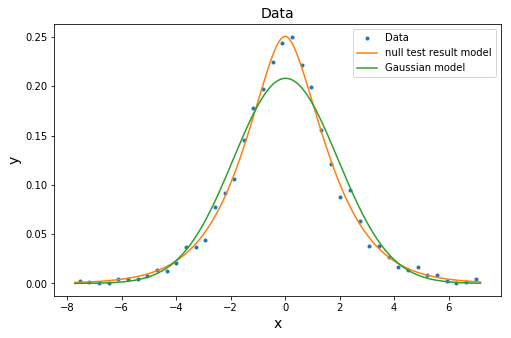

In [286]:
x1 = np.random.normal(size=(2, 4000)).view(np.complex128)
z1 = x1[0, :] * x1[1, :]
x2 = np.random.normal(size=(2, 4000)).view(np.complex128)
z2 = x2[0, :] * x2[1, :]
n = z1.real-z2.real

y, x = np.histogram(n, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

sig1 = curve_fit(null_pdf, x, y, p0=np.std(n))[0]
mu = norm.fit(n)[0]
std = norm.fit(n)[1]

xfit = np.linspace(min(n), max(n), 1000)
plt.figure(figsize=(8, 5))
y, x = np.histogram(n, bins='auto', density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
plt.plot(x, y, '.', label='Data')
plt.plot(xfit, null_pdf(xfit, sig1), label='null test result model')
plt.plot(xfit, norm.pdf(xfit, mu, std), label='Gaussian model')
plt.legend(loc='best', fontsize=10)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title("Data", fontsize=14)
plt.show()